In [3]:
%load_ext autoreload
%autoreload 2

from utils.visualize_nii import visualize_mri_sample
from data.bonn_data import BonnMRIClassificationDataset
import torch
import matplotlib.pyplot as plt

from models.classifier import FCDDetector
import os
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

from data.bonn_data import OverfittingDataset

model = FCDDetector()

data = BonnMRIClassificationDataset('./Dataset')

sample = data[0]

model.encoder(sample['FLAIR'].unsqueeze(0).float())


device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Using deivce:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using deivce: cuda


Initially we will overfit to a small dataset to see if the model has enough capacity to overfit

In [ ]:


optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss with logits

num_of_overfitting_samples = 10

overfitting_dataset = OverfittingDataset(bonn_dataset=data, num_samples=num_of_overfitting_samples)

train_loader = DataLoader(overfitting_dataset, batch_size=num_of_overfitting_samples, shuffle=False)

num_epochs = 30  # Define the number of epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch in train_loader:
            inputs = batch['FLAIR'].float()  # Input MRI data
            labels = batch['label'].float()  # Corresponding labels (convert to float for BCEWithLogitsLoss)

            # Move data to GPU if available
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()
                model = model.cuda()

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], ", f"Train Loss: {running_loss / len(train_loader):.4f}")

    # Calculate accuracy, precision, and recall
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    with torch.no_grad():
        for batch in train_loader:
            inputs = batch['FLAIR'].float()
            labels = batch['label'].float()

            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            outputs = model(inputs).squeeze(1)
            predicted = (torch.sigmoid(outputs) > 0.5).float()

            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

            true_positives += ((predicted == 1) & (labels == 1)).sum().item()
            false_positives += ((predicted == 1) & (labels == 0)).sum().item()
            false_negatives += ((predicted == 0) & (labels == 1)).sum().item()

    accuracy = correct_predictions / total_predictions
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

Epoch [1/30],  Train Loss: 0.7381
Accuracy: 0.6000, Precision: 0.6000, Recall: 1.0000
Epoch [2/30],  Train Loss: 0.7252
Accuracy: 0.6000, Precision: 0.6000, Recall: 1.0000
Epoch [3/30],  Train Loss: 0.7139


KeyboardInterrupt: 

tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
        1, 1, 1, 0, 0, 0, 1, 1, 0])
Epoch [1/30], Train Loss: 0.7140, Validation Loss: 0.6594, Validation Accuracy: 0.4242, Precision: 0.4242, Recall: 1.0000
Epoch [2/30], Train Loss: 0.6461, Validation Loss: 0.6321, Validation Accuracy: 0.4848, Precision: 0.4444, Recall: 0.8571
Epoch [3/30], Train Loss: 0.6605, Validation Loss: 0.5712, Validation Accuracy: 0.7576, Precision: 0.7500, Recall: 0.6429
Epoch [4/30], Train Loss: 0.5740, Validation Loss: 0.5600, Validation Accuracy: 0.7273, Precision: 0.6667, Recall: 0.7143
Epoch [5/30], Train Loss: 0.5685, Validation Loss: 0.5504, Validation Accuracy: 0.7273, Precision: 0.6667, Recall: 0.7143
Epoch [6/30], Train Loss: 0.5491, Validation Loss: 0.5503, Validation Accuracy: 0.6667, Precision: 0.5882, Recall: 0.7143
Epoch [7/30], Train Loss: 0.5906, Validation Loss: 0.5056, Validation Accuracy: 0.7879, Precision: 0.7692, Recall: 0.7143
Epoch [8/30], Train Loss: 0.59

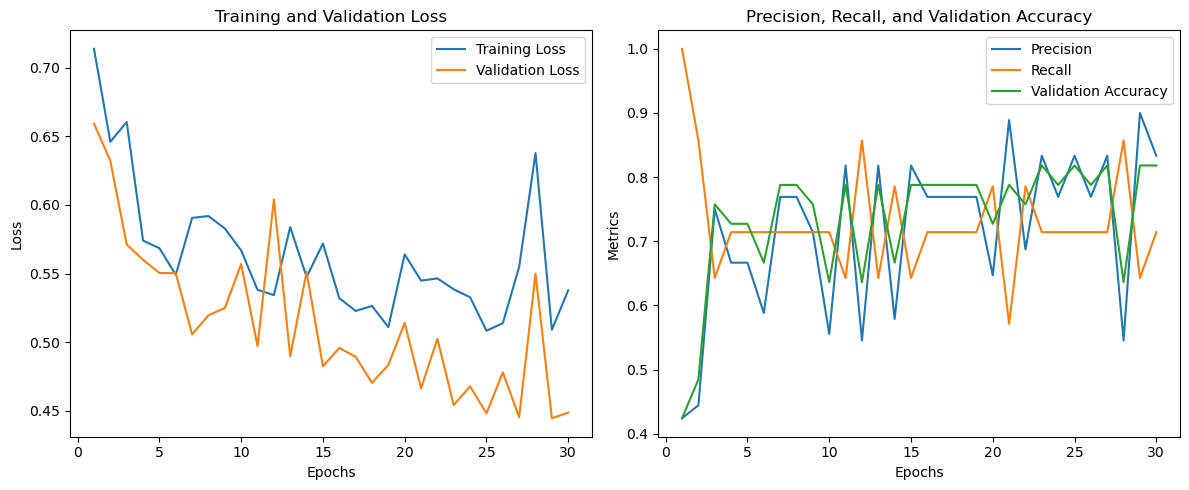

In [4]:
torch.cuda.empty_cache()

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss with logits

# Split the dataset into train, validation, and test sets
train_size = int(0.8 * len(data))
val_size = len(data) - train_size
train_data, val_data = random_split(data, [train_size, val_size])

# Create DataLoaders for train and validation datasets
batch_size = 20  # Define batch size
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=val_size, shuffle=False)

# Initialize lists to store loss information
train_losses = []
val_losses = []

# Collect precision, recall, and validation accuracy for each epoch
precisions = []
recalls = []
val_accuracies = []

# Print all the labels in the validation loader
for val_batch in val_loader:
    print(val_batch['label'])

# Training loop with validation
num_epochs = 30  # Define the number of epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch in train_loader:
        inputs = batch['FLAIR'].float()  # Input MRI data
        labels = batch['label'].float()  # Corresponding labels (convert to float for BCEWithLogitsLoss)

        # Move data to GPU if available
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()
            model = model.cuda()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs).squeeze(1)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate validation loss and accuracy
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for val_batch in val_loader:
            val_inputs = val_batch['FLAIR'].float()
            val_labels = val_batch['label'].float()

            if torch.cuda.is_available():
                val_inputs = val_inputs.cuda()
                val_labels = val_labels.cuda()

            val_outputs = model(val_inputs).squeeze(1)
            val_loss += criterion(val_outputs, val_labels).item()

            # Calculate accuracy
            predicted = (torch.sigmoid(val_outputs) > 0.5).float()
            correct_predictions += (predicted == val_labels).sum().item()
            total_predictions += val_labels.size(0)

    val_accuracy = correct_predictions / total_predictions

    # Calculate precision and recall
    true_positives = ((predicted == 1) & (val_labels == 1)).sum().item()
    false_positives = ((predicted == 1) & (val_labels == 0)).sum().item()
    false_negatives = ((predicted == 0) & (val_labels == 1)).sum().item()

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    # Store losses
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))

    # Print epoch loss and accuracy
    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Train Loss: {running_loss / len(train_loader):.4f}, "
          f"Validation Loss: {val_loss / len(val_loader):.4f}, "
          f"Validation Accuracy: {val_accuracy:.4f}, "
          f"Precision: {precision:.4f}, "
          f"Recall: {recall:.4f}"
    )

    precisions.append(precision)
    recalls.append(recall)
    val_accuracies.append(val_accuracy)

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Precision, Recall, and Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), precisions, label='Precision')
plt.plot(range(1, num_epochs + 1), recalls, label='Recall')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Precision, Recall, and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()